In [1]:
# First lets import most neccesary libs
import pandas as pd
import numpy as np
# Library to import pre-trained model for sentence embeddings
from sentence_transformers import SentenceTransformer
# Calculate similaritie between sentences
from sklearn.metrics.pairwise import cosine_similarity
# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt
# package for finding local minimas
from scipy.signal import argrelextrema

#!!!!!! RENEW
import math



/home/poloniki/.pyenv/versions/3.8.12/envs/quint/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this article I want to show approach that we are going to use in our project of podcast summarization.

First, what do we want to achieve? We need to split text into meaningfull parts. 
How are we going to approach this? 
We need to turn text into something that machine can understand - vectors. In Neuteral Language Processing vector representation of a text is called - Embedding. There two ways how to create it:
1) Create our embedding which is based on texts which will be similar to the ones that we expect our function to accept (I will cover it in next article)
2) Use pretrained embedding. 

Second option is faster and can already give us reasonable results. There number of pre-trained embeddings. In our case we are going to choose one this ones: https://www.sbert.net/docs/pretrained_models.html .

Right now we will simply go for a best overall perfomance embedding - "all-mpnet-base-v2".
First things first - we load the model.

In [2]:
# Loading a model - don't try it at home, it might take some time - it is 420 mb
model = SentenceTransformer('all-mpnet-base-v2')

Now lets check how does it work and what can we achive with this. Lets say we have some text:


In [3]:
text = '''Let me tell you a little story. When I was little kid I really liked to play football. I wanted to be like Messi and play on Camp nou. However, 
I was really bad at it and now I'm not training at Camp Nou. I'm writing medium article on embeddings.'''

We first need to split into sentences and then embedd them into vectors.

In [4]:
# Split text into sentences
sentences = text.split('. ')
# Embed sentences
embeddings = model.encode(sentences)
print(embeddings.shape)

(5, 768)


Magic happened, we just turned our 4 sentences into 768-dimensional world. Now, how is this usefull? Well, now sentences are vectors and we can check how close those vectors are in the 768-dimensions and there is very simple way to do that - dot product.

In [5]:
#select  row (sentence) and all columns
first_sentence = embeddings[0,:] 
second_sentence = embeddings[1,:]
third_sentence = embeddings[2,:] 
fourth_sentence = embeddings[3,:] 
fifth_sentence = embeddings[4,:] 

# How similar is second and third sentence
print(f'Dot product of second and third sentence is {second_sentence @ third_sentence}')
print(f'Dot product of third and fourth sentence is {third_sentence @ fourth_sentence}')
print(f'Dot product of fourth and fith sentence is {fourth_sentence @ fifth_sentence}')

Dot product of second and third sentence is 0.4578239619731903
Dot product of third and fourth sentence is 0.4315364956855774
Dot product of fourth and fith sentence is -0.07396048307418823


From this results we can clearly see where topic of playing football changed to writing an article and this would really helpfull in our task. But, of course, there is a better way to see sentence similarities all at once - create similarity matrix. And because sklearn has a handy function of computing similarities with cosine_similarity function - we are going to use it. Why not use the dot product? Well, when vectors have the same lenght(magnitude) there is no difference between dot product and cosine similarity. I only showed dot product to explain how it works under the hood.

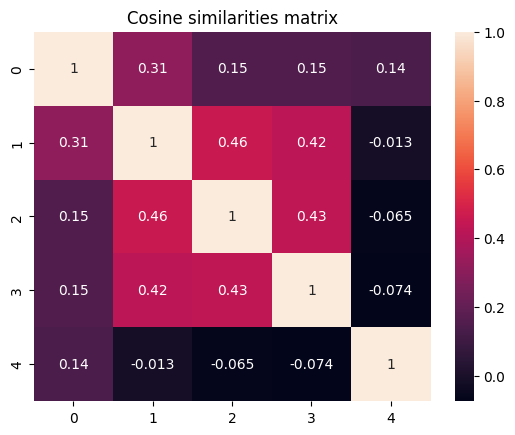

In [6]:
# Create similarities matrix
similarities = cosine_similarity(embeddings)
# Lets plot the result we got
sns.heatmap(similarities,annot=True).set_title('Cosine similarities matrix');

There is an interesting pattern we can spot there. Red square in the middle is basically a part where I talk about football and from this graph we can clearly see that the last sentence about football is index-3 or fourth sentence. Now how would it look like if we changed topics two times?

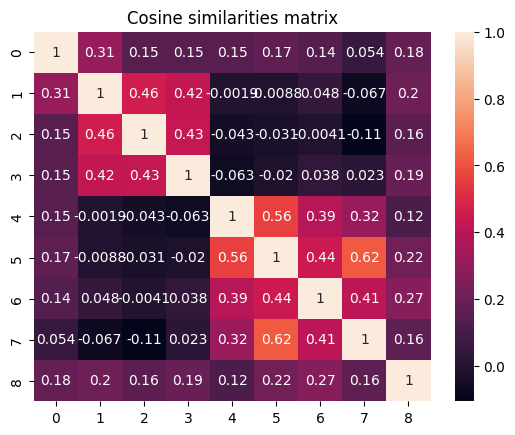

In [669]:
text = '''Let me tell you a little story. When I was little kid I really liked to play football. I wanted to be like Messi and play on Camp nou. However, I was really bad at it and now I'm not training at Camp Nou. I'm writing medium article on embeddings. In this article I want to show how are we going to split text into parts.We first embed sentences. Than we compute sentence similarities. After that we detect split point in the text. After finishing this process we will go play chess with freinds.'''
# repeat all the steps
sentences = text.split('. ')
# Embed sentences
embeddings = model.encode(sentences)
# Create similarities matrix
similarities = cosine_similarity(embeddings)
# Lets plot the result we got
sns.heatmap(similarities,annot=True).set_title('Cosine similarities matrix');

You probably already starting to get the pattern. We can clearly see two different topics and their split points. Now lets change from small text to smth that we are going to do in reality - chunking transcripts of long videos and podcasts. During last presentation Pato asked if if we can do summarization for one specic  video: "8. The Sumerians - Fall of the First Cities" - https://www.youtube.com/watch?v=d2lJUOv0hLA . Well, I did not forget =)

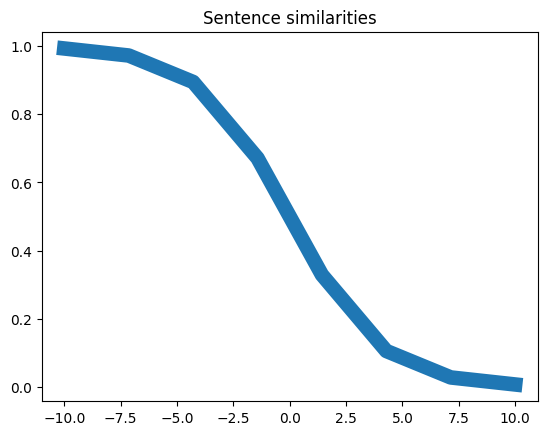

In [670]:
def rev_sigmoid(x):
    return (1 / (1 + math.exp(0.5*x)))

x = np.linspace(-10,10,8)
y = np.vectorize(rev_sigmoid)
sns.lineplot(y=y(x), x=x, linewidth = 10.5).set_title('Sentence similarities');

In [671]:
def rev_sigmoid(x):
    return (1 / (1 + math.exp(0.5*x)))

def activate_similarities(similarities, p_size=10):
    # Create reversed sigmoid activation

    x = np.linspace(-10,10,p_size)
    y = np.vectorize(rev_sigmoid)
    y = np.pad(y(x),(0,similarities.shape[0]-p_size))
    
    # Get every diagonal in our similarity matrix
    diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
    # Because each diagonal is different length we should pad it with zeros at the end
    diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
    # Lets combine the result into matrix
    diagonals = np.stack(diagonals)
    # Multiply similarities with our activation
    diagonals = diagonals * y.reshape(-1,1)
    # Get the sum of activated similarities
    activated_similarities = np.sum(diagonals, axis=0)
    return activated_similarities
change_points

array([1.37045001, 1.62804773, 1.36843541, 0.92870871, 1.73481777,
       1.72792224, 1.50454316, 1.14472388, 0.99330727])

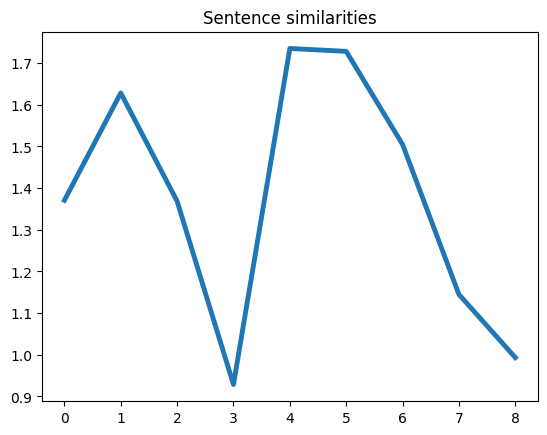

In [672]:
change_points = activate_similarities(similarities, p_size=5)
sns.lineplot(y=change_points, x=range(len(change_points)), linewidth = 3.5).set_title('Sentence similarities');

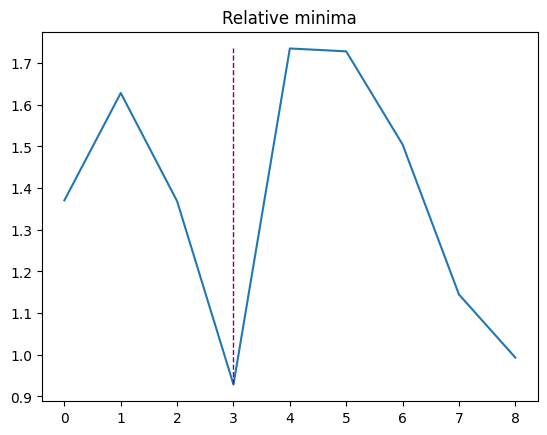

In [675]:
fig, ax = plt.subplots()
# for all local minimals
median_similarity =change_points
minmimals = argrelextrema(median_similarity, np.less, order=2)
sns.lineplot(y=median_similarity, x=range(len(median_similarity)), ax=ax).set_title('Relative minima');
# Now lets plot vertical line in order to understand if we have done what we wanted
plt.vlines(x=minmimals, ymin=min(median_similarity), ymax=max(median_similarity), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

In [690]:
# First lets load the transcript
with open('../quint/frontend/transcripts/podcast_transcript.txt') as f:
    doc = f.readlines()
    f.close()
# Transcript is one line, so we select it and change question mark for dots so that we split it correctly.
doc = doc[0].replace("?", ".")
sentences = doc.split('. ')
print('Loaded Text String')

Loaded Text String


In [691]:
for i,each in enumerate(sentences[:20]):
    print(i,each)

0 In the year 1625, an Italian nobleman named Pietro de la Valet went on a tour of the Middle East
1 De la Valle was a prolific traveler
2 He journeyed around Asia, North Africa and even India
3 He married an Assyrian Christian princess in Damascus and now the two of them traveled together, journeying by horseback and camel, accompanied by local guides
4 At this time, travel in this region couldn't have been more dangerous
5 The Ottoman and Persian empires were at war, fighting over who would rule in Baghdad
6 And meanwhile, local bandits took advantage of the chaos to prey on travelers
7 In those days, lions even roamed in these hills
8 Due to these various dangers, dela Valets guides were constantly on edge
9 It was June 18, 1625 when they spotted a distant group of tribesmen on the horizon
10 Their guides decided that they might be in danger and began to search for a place to hide
11 In the distance, they spotted the looming mass of a series of enormous ruins
12 As Dela Valley later

There is a problem there. We can see some nice devision in sentence 34 "34 My name is Paul Cooper, and you're listening to the Fall of Civilization's podcast" which makes a lot of sense. But 21 Two I found in many places is not a good one and the reason for it - it is short. Apparently shorter the sentence the less chance it will find similarities in other sentences. Now, lets check if this correlation exists. Lets create a df a plot scatterplot.

We can see our squares but not as clearly, so lets do a little round up to clarify the picture. We should look for those bold black lines and I can count 5 of them.

In [692]:
sentece_length = [len(each) for each in sentences]

Now how can we get rid of this correlation. First thought is to try the simpliest approach - concatenate short sentences to long ones and lets break long sentences into short. Lets see.

In [693]:
long = np.mean(sentece_length) + np.std(sentece_length) *2
short = np.mean(sentece_length) - np.std(sentece_length) *2
short

-1.4137699921083282

In [694]:
# Lets first shorten up long sentences
text = ''
for each in sentences:
    if len(each) > long:
        # lets replace all the commas with dots
        comma_splitted = each.replace(',', '.')
    else:
        text+= f'{each}. '
sentences = text.split('. ')

In [697]:
# Now lets concatenate short ones
text = ''
for each in sentences:
    if len(each) < short:
        text+= f'{each} '
    else:
        text+= f'{each}. '
sentences = text.split('. ')
# Now we know the drill, lets repeat the process and see the result
embeddings = model.encode(sentences)


KeyboardInterrupt: 

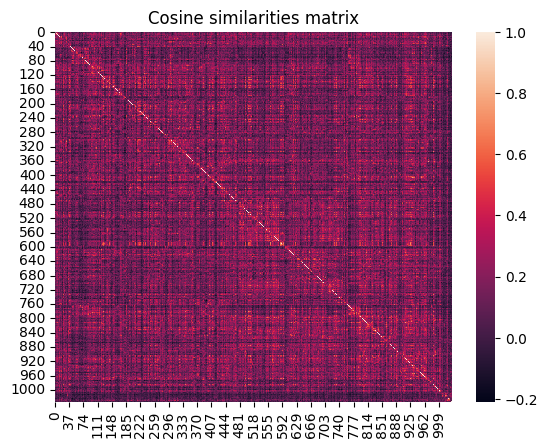

In [698]:
# Create similarities matrix
similarities = cosine_similarity(embeddings)
# Lets plot the result we got
sns.heatmap(similarities).set_title('Cosine similarities matrix');

In [696]:
median_similarity = activate_similarities(similarities, p_size=10)

Now lets repeat the process and compare the results.

<AxesSubplot:>

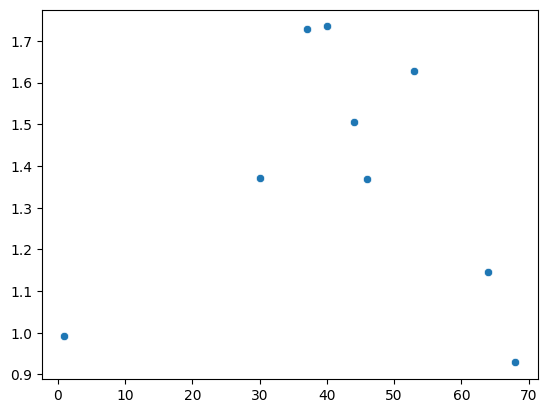

In [689]:
sentece_length = [len(each) for each in sentences]
sns.scatterplot(x=sentece_length,y=median_similarity)

Now there is almost no correlation.

This looks really noizy, but we can improve on this graph by taking all the noize away with lowpass filter. 

Now we can much better see how topics are changing inside the transcript. Now the question might seem simple but it is not. How do we exact point of change? As we before on our small example it would make the most sense to select first instance of rapid change. For that reason lets plot the differences between each point to get a better view.

Now we should get all thoose low points

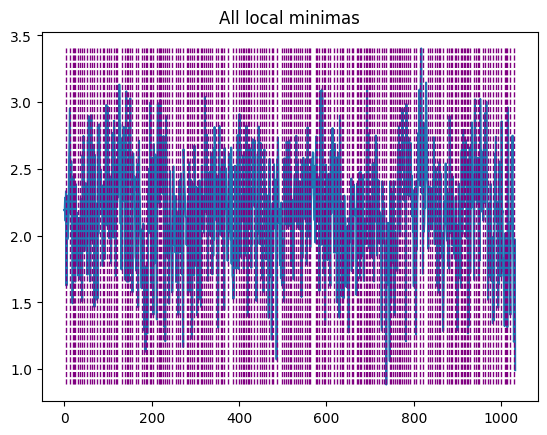

In [639]:
fig, ax = plt.subplots()
# for all local minimals
minmimals = argrelextrema(median_similarity, np.less, order=2)
sns.lineplot(y=median_similarity, x=range(len(median_similarity)), ax=ax).set_title('All local minimas');
# Now lets plot vertical line in order to understand if we have done what we wanted
plt.vlines(x=minmimals, ymin=min(median_similarity), ymax=max(median_similarity), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

Perfect! Now we have all of the splitting points! Lets check how it performed on our podcast.

Lets zoom in a little and see what kind of points are beeing picked up


(0.0, 100.0)

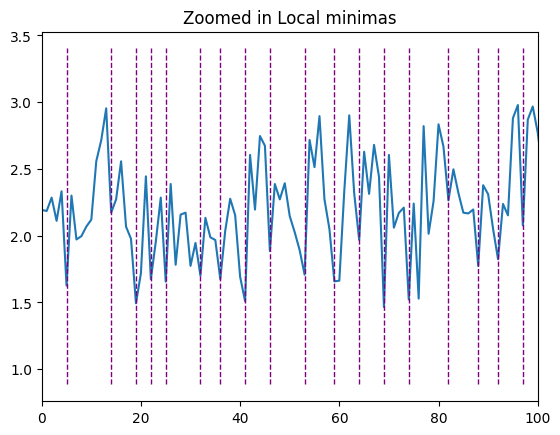

In [640]:
fig, ax = plt.subplots()
# for all local minimals
sns.lineplot(y=median_similarity, x=range(len(median_similarity)), ax=ax).set_title('Zoomed in Local minimas');
# Now lets plot vertical line in order to understand if we have done what we wanted
plt.vlines(x=minmimals, ymin=min(median_similarity), ymax=max(median_similarity), colors='purple', ls='--', lw=1, label='vline_multiple - full height')
ax.set_xlim([0,100])

In [641]:
# We can see that we target 

In [642]:
# Create empty string
split_points = [each for each in minmimals[0]]
text = ''
for num,each in enumerate(sentences):
    if num in split_points:
        text+=f'\n\n {each}. '
    else:
        text+=f'{each}. '

In [643]:
print(text)

In the year 1625, an Italian nobleman named Pietro de la Valet went on a tour of the Middle East. De la Valle was a prolific traveler. He journeyed around Asia, North Africa and even India. He married an Assyrian Christian princess in Damascus and now the two of them traveled together, journeying by horseback and camel, accompanied by local guides. At this time, travel in this region couldn't have been more dangerous. 

 The Ottoman and Persian empires were at war, fighting over who would rule in Baghdad. And meanwhile, local bandits took advantage of the chaos to prey on travelers. In those days, lions even roamed in these hills. Due to these various dangers, dela Valets guides were constantly on edge. It was June 18, 1625 when they spotted a distant group of tribesmen on the horizon. Their guides decided that they might be in danger and began to search for a place to hide. In the distance, they spotted the looming mass of a series of enormous ruins. Our removal hence being still defe

Meanwhile not all paragrpahs are perfect, we can see some pretty good ones. Like it splitted out "My name is Paul Cooper.." in the beggining or in the end "I want to thank all.." or charity part - "And I thought it would be fitting to take'

In [207]:
# This is the end of first chapter - creating automated paragraphs. Now lets talk about chapters - What is chapter

I think this is a good start and there are several ways I want to improve this

In [677]:
25 ** 0.5

5.0

In [680]:
def simple_multiplication(n) :
    return n * (8 + n%2)
simple_multiplication(3)

27

In [682]:
def first_non_consecutive(arr):
    consequent = list(range(arr[0], arr[-1]))
    n_c = [each for each in consequent if each not in arr]
    return n_c[0]

In [683]:
first_non_consecutive([2,3,4,5,7])

6